In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import  mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the data 
data=pd.read_csv('data_final_Rand.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data.head()

DEXSFUS  fit_arim1   fit_esp1   fit_lrf1  res_arim1  res_esp1  \
DATE                                                                        
2015-01-01  11.5425  11.530958  11.541389  11.748431   0.011542  0.000096   
2015-01-02  11.6990  11.542500  11.542500  11.696556   0.156500  0.013559   
2015-01-05  11.7155  11.699000  11.698984  11.630803   0.016500  0.001412   
2015-01-06  11.7005  11.715500  11.715498  11.556821  -0.015000 -0.001280   
2015-01-07  11.7075  11.700500  11.700502  11.478391   0.007000  0.000598   

            res_lrf1  fit_tarim1  fit_tesp1  res_tarim1  res_tesp1  
DATE                                                                
2015-01-01 -0.205931   11.736695  11.751652    0.011735  -0.003222  
2015-01-02  0.002444   11.698305  11.695932   -0.001750   0.000624  
2015-01-05  0.084697   11.633001  11.645895   -0.002198  -0.015092  
2015-01-06  0.143679   11.554115  11.566593    0.002706  -0.009771  
2015-01-07  0.229109   11.476959  11.484572    0.001432  -0.006181

In [3]:
# This function is to transform a time series dataset into a format suitable for training machine learning models, where:
# X contains sequences of past observations (input features). y contains the next observation (target value) that the model will learn to predict.
def data_toX_y (data, window):
    data_np=data.to_numpy()
    X=[]
    y=[]
    for i in range(len(data_np)-window):
        row= [[a] for a in data_np[i:i+window]]
        X.append(row)
        label=data_np[i+window]
        y.append(label)
    return np.array(X), np.array(y)

In [4]:
# The function help to evaluate the performances of each model
def metrics(y_true, y_pred):
    # Convert inputs to lists
    y_true_list = np.array(y_true)
    y_pred_list = np.array(y_pred)
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((np.array(y_true_list) - np.array(y_pred_list)) ** 2))
    
    # Calculate SMAPE
    smape = np.mean(np.abs(y_true_list-y_pred_list )/((np.abs(y_true_list)+np.abs(y_pred_list))/2))
    
    return rmse, smape

# Performances of single models

In [5]:
#Arima
print('train:', metrics(data['DEXSFUS'][:2067],data['fit_arim1'][:2067]))
print('test:' , metrics(data['DEXSFUS'][2067:],data['fit_arim1'][2067:]))

train: (np.float64(0.14776775297454198), np.float64(0.007529317998264391))
test: (np.float64(0.28737683883709125), np.float64(0.01424952926438099))


In [6]:
#ES
print('train:', metrics(data['DEXSFUS'][:2067],data['fit_esp1'][:2067]))
print('test:' , metrics(data['DEXSFUS'][2067:],data['fit_esp1'][2067:]))

train: (np.float64(0.14776782179329853), np.float64(0.007528889110846354))
test: (np.float64(0.2873907986335088), np.float64(0.014250205986363701))


In [7]:
#SSA-R
print('train:', metrics(data['DEXSFUS'][:2067],data['fit_lrf1'][:2067]))
print('test:' , metrics(data['DEXSFUS'][2067:],data['fit_lrf1'][2067:]))

train: (np.float64(0.18531369996353086), np.float64(0.010017832630979981))
test: (np.float64(0.26457819954678813), np.float64(0.011668953029894175))


# ARIMA-LSTM (LSTM on residuals of Arima)

In [8]:
# We scale the residuals
scaler = MinMaxScaler(feature_range=(0, 1))
data_ = np.array(data['res_arim1']).reshape(-1, 1)
data_= scaler.fit_transform(data_)
data_=pd.Series(data_.reshape(-1))
s=data_[:5]
data_=pd.concat([s,data_])

In [9]:
### Divide the data to train and test
window=5
X,y=data_toX_y(data_,window)

X_train,y_train= X[:2067],y[:2067]
X_test,y_test= X[2067:],y[2067:]
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((2067, 5, 1), (2067,), (20, 5, 1), (20,))

In [10]:
# Set the seed
tf.keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [12]:
##LSTM structure
m=Sequential()
m.add(InputLayer((5,1)))
m.add(LSTM(200, return_sequences=True))
m.add(LSTM(50))
m.add(Dense(1,'relu'))
m.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 200)              │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          50,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 211,851 (827.54 KB)

 Trainable params: 211,851 (827.54 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#Compile the model
m.compile(loss=MeanSquaredError(),optimizer="Adam",metrics=[RootMeanSquaredError()])
#Train the model
history=m.fit(X_train,y_train,validation_split=0.2, epochs=100 ,batch_size=32)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0933 - root_mean_squared_error: 0.2889 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - root_mean_squared_error: 0.0922 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0886
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0085 - root_mean_squared_error: 0.0922 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step -

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 87/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 88/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 89/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 90/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 91/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 

In [14]:
#Predict the train set
train_p=m.predict(X_train).flatten()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [15]:
#Use the model to generate 20 next days forecast based on its prediction
ntest = X_test.shape[0]
m_input = X_train[-1:]
test_p = np.zeros(ntest)
for i in range(ntest):
    pred = m.predict(m_input)
    test_p[i] = pred[0]
    m_input = np.roll(m_input, -1)
    m_input[0,-1,0] = pred[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

C:\Users\loic\AppData\Local\Temp\ipykernel_6660\3452362541.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_p[i] = pred[0]
C:\Users\loic\AppData\Local\Temp\ipykernel_6660\3452362541.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_input[0,-1,0] = pred[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [16]:
#Inversion of the scaling
train_p=scaler.inverse_transform(train_p.reshape(-1,1))
test_p=scaler.inverse_transform(test_p.reshape(-1,1))
train_p=train_p.reshape(-1)
test_p=test_p.reshape(-1)

In [17]:
# ARIMA-LSTM (we sum the results of the fitted ARIMA model with the forecast of the residuals).

print('train:', metrics(data['DEXSFUS'][:2067],data['fit_arim1'][:2067]+train_p))
print('test:' , metrics(data['DEXSFUS'][2067:],data['fit_arim1'][2067:]+test_p))

train: (np.float64(0.1482607705221181), np.float64(0.007568514389266039))
test: (np.float64(0.2801779442772842), np.float64(0.013867688235343659))


# ES-LSTM (LSTM on residuals of ES )

For this cas the code is the same that the case of ARIMA-LSTM but we just replace res_arim1 and fit_arim1 by res_esp1 and fit_esp1 respectively

# SSA-R-LSTM (LSTM on the noice )

In [8]:
#Prepare the data
data_=data['res_lrf1']
s=data_[:5]
data_=pd.concat([s,data_])

###
window=5
X,y=data_toX_y(data_,window)

X_train,y_train= X[:2067],y[:2067]
X_test,y_test= X[2067:],y[2067:]

In [9]:
# Set the seed
tf.keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [10]:
del m

NameError: name 'm' is not defined

In [11]:
#LSTM Structure
m=Sequential()
m.add(InputLayer((5,1)))
m.add(LSTM(250))
m.add(Dense(1,'relu'))
m.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 250)                 │         252,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,251 (985.36 KB)

 Trainable params: 252,251 (985.36 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
#Compile the model
m.compile(loss=MeanSquaredError(),optimizer="Adam",metrics=[RootMeanSquaredError()])

In [13]:
#Train the model
history=m.fit(X_train,y_train,validation_split=0.2, epochs=100 ,batch_size=32)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0317 - root_mean_squared_error: 0.1781 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1610
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0257 - root_mean_squared_error: 0.1601 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1566
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0244 - root_mean_squared_error: 0.1562 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1548
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0239 - root_mean_squared_error: 0.1545 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1544
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0238 - root_mean_squared_error: 0.1540 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0237 - root_mean_squared_error: 0.1539 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1542
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step 

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0234 - root_mean_squared_error: 0.1528 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1538
Epoch 44/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0234 - root_mean_squared_error: 0.1527 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1539
Epoch 45/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0234 - root_mean_squared_error: 0.1527 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1541
Epoch 46/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0234 - root_mean_squared_error: 0.1527 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1541
Epoch 47/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0233 - root_mean_squared_error: 0.1526 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 48/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0233 - root_mean_squared_error: 0.1524 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 49/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0229 - root_mean_squared_error: 0.1511 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0229 - root_mean_squared_error: 0.1510 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 87/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 88/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 89/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 90/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1553
Epoch 91/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss

In [14]:
#Predict the train set
train_p=m.predict(X_train).flatten()

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [15]:
#Use the model to generate 20 next days forecast based on its prediction
ntest = X_test.shape[0]
m_input = X_train[-1:]
test_p = np.zeros(ntest)
for i in range(ntest):
    pred = m.predict(m_input)
    test_p[i] = pred[0]
    m_input = np.roll(m_input, -1)
    m_input[0,-1,0] = pred[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

C:\Users\loic\AppData\Local\Temp\ipykernel_9344\3452362541.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_p[i] = pred[0]
C:\Users\loic\AppData\Local\Temp\ipykernel_9344\3452362541.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_input[0,-1,0] = pred[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [16]:
# SSA-R-LSTM (we sum the results of the fitted ARIMA model with the forecast of the residuals).

print('train:', metrics(data['DEXSFUS'][:2067],data['fit_lrf1'][:2067]+train_p))
print('test:' , metrics(data['DEXSFUS'][2067:],data['fit_lrf1'][2067:]+test_p))

train: (np.float64(0.15546352525036944), np.float64(0.008273885195467217))
test: (np.float64(0.26352428797609206), np.float64(0.011786628031105428))


# SSA-ARIMA-LSTM (LSTM on residuals of SSA-ARIMA and LSTM on the noise)

LSTM on residuals of SSA-ARIMA

In [28]:
# We scale the residuals
scaler = MinMaxScaler(feature_range=(0, 1))
data_ = np.array(data['res_tarim1']).reshape(-1, 1)
data_= scaler.fit_transform(data_)
data_=pd.Series(data_.reshape(-1))
s=data_[:5]
data_=pd.concat([s,data_])

In [29]:
# Prepare the data
window=5
X,y=data_toX_y(data_,window)

X_train,y_train= X[:2067],y[:2067]
X_test,y_test= X[2067:],y[2067:]

In [30]:
# Set the seed
tf.keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [31]:
# delete the previous model
del m

NameError: name 'm' is not defined

In [32]:
#LSTM Structure
m=Sequential()
m.add(InputLayer((5,1)))
m.add(LSTM(200, return_sequences=True))
m.add(LSTM(50))
m.add(Dense(1,'relu'))
m.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 5, 200)              │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          50,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 211,851 (827.54 KB)

 Trainable params: 211,851 (827.54 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
#Compile the model
m.compile(loss=MeanSquaredError(),optimizer="Adam",metrics=[RootMeanSquaredError()])

In [34]:
#Train the model
history=m.fit(X_train,y_train,validation_split=0.2, epochs=100 ,batch_size=32)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0128 - root_mean_squared_error: 0.1048 - val_loss: 4.6223e-05 - val_root_mean_squared_error: 0.0068
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3497e-05 - root_mean_squared_error: 0.0047 - val_loss: 1.2653e-05 - val_root_mean_squared_error: 0.0036
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3311e-07 - root_mean_squared_error: 7.9328e-04 - val_loss: 1.2296e-05 - val_root_mean_squared_error: 0.0035
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.5521e-07 - root_mean_squared_error: 7.4003e-04 - val_loss: 1.2316e-05 - val_root_mean_squared_error: 0.0035
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6152e-07 - root_mean_squared_error: 7.4456e-04 - val_loss: 1.2321e-05 - val_root_mean_squared_error: 0.0035
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.6367e-07 - root_mean_squared_error: 7.4605e-04 - val_loss: 1.2336e-05 - val_root_mean_squared_error: 0

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.2909e-07 - root_mean_squared_error: 9.5912e-04 - val_loss: 1.2748e-05 - val_root_mean_squared_error: 0.0036
Epoch 82/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.2583e-07 - root_mean_squared_error: 9.5725e-04 - val_loss: 1.2448e-05 - val_root_mean_squared_error: 0.0035
Epoch 83/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.9147e-07 - root_mean_squared_error: 9.3817e-04 - val_loss: 1.2357e-05 - val_root_mean_squared_error: 0.0035
Epoch 84/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.6338e-07 - root_mean_squared_error: 9.2171e-04 - val_loss: 1.2356e-05 - val_root_mean_squared_error: 0.0035
Epoch 85/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.7219e-07 - root_mean_squared_error: 9.2468e-04 - val_loss: 1.2385e-05 - val_root_mean_squared_error: 0.0035
Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.1171e-07 - root_mean_squared_error: 9.4346e-04 - val_loss: 1.2446e-05 - val_root_mean_squared_e

In [35]:
# predict the train set
train_p=m.predict(X_train).flatten()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [36]:
# Generate 20 Forecat
ntest = X_test.shape[0]
m_input = X_train[-1:]
test_p = np.zeros(ntest)
for i in range(ntest):
    pred = m.predict(m_input)
    test_p[i] = pred[0]
    m_input = np.roll(m_input, -1)
    m_input[0,-1,0] = pred[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


C:\Users\loic\AppData\Local\Temp\ipykernel_6660\2962540901.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_p[i] = pred[0]
C:\Users\loic\AppData\Local\Temp\ipykernel_6660\2962540901.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_input[0,-1,0] = pred[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [37]:
# Inversion of the scaling
train_p=scaler.inverse_transform(train_p.reshape(-1,1))
test_p=scaler.inverse_transform(test_p.reshape(-1,1))
train_p=train_p.reshape(-1)
test_p=test_p.reshape(-1)
train_p[:20]

array([ 8.5008168e-04,  2.1775700e-04,  7.6443155e-04,  1.0904521e-03,
        9.1629213e-04,  8.5008168e-04, -3.0967087e-04, -7.5682474e-05,
        1.4275759e-04, -2.3805119e-04, -5.2525959e-04, -5.3919770e-04,
       -6.3598499e-04, -5.5635627e-04, -2.4195085e-04,  4.8100505e-05,
        1.8090724e-04,  3.0449734e-04,  2.8960311e-04,  4.0938536e-05],
      dtype=float32)

In [38]:
# Save the results of the SSA-ARIMA residuals
train_p1=train_p
test_p1=test_p

LSTM on the noise

In [39]:
#prepare the data
data_=data['res_lrf1']
s=data_[:5]
data_=pd.concat([s,data_])
###
window=5
X,y=data_toX_y(data_,window)

X_train,y_train= X[:2067],y[:2067]
X_test,y_test= X[2067:],y[2067:]

In [40]:
#Set the seed
tf.keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [ ]:
del m

In [41]:
#LSTM Structure
m=Sequential()
m.add(InputLayer((5,1)))
m.add(LSTM(250))
m.add(Dense(1,'relu'))
m.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 250)                 │         252,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,251 (985.36 KB)

 Trainable params: 252,251 (985.36 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
#Compile the model
m.compile(loss=MeanSquaredError(),optimizer="Adam",metrics=[RootMeanSquaredError()])

In [43]:
#Train the model
history=m.fit(X_train,y_train,validation_split=0.2, epochs=100 ,batch_size=32)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0317 - root_mean_squared_error: 0.1781 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1610
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0257 - root_mean_squared_error: 0.1601 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1566
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0244 - root_mean_squared_error: 0.1562 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1548
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0239 - root_mean_squared_error: 0.1545 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1544
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0238 - root_mean_squared_error: 0.1540 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0237 - root_mean_squared_error: 0.1539 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1542
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step -

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0229 - root_mean_squared_error: 0.1511 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0229 - root_mean_squared_error: 0.1510 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 87/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 88/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 89/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 90/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1553
Epoch 91/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss

In [44]:
# Predict the train set
train_p=m.predict(X_train).flatten()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [45]:
# Generate 20 forecasts
ntest = X_test.shape[0]
m_input = X_train[-1:]
test_p = np.zeros(ntest)
for i in range(ntest):
    pred = m.predict(m_input)
    test_p[i] = pred[0]
    m_input = np.roll(m_input, -1)
    m_input[0,-1,0] = pred[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\loic\AppData\Local\Temp\ipykernel_6660\2272936751.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_p[i] = pred[0]
C:\Users\loic\AppData\Local\Temp\ipykernel_6660\2272936751.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_input[0,-1,0] = pred[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [46]:
# Add the results to the previous residual of SSA-ARIMA 
train_p=train_p1+train_p
test_p=test_p1+test_p

In [47]:
# SSA-ARIMA-LSTM (we sum the results of the fitted ARIMA model with the forecast of the residuals).

print('train:', metrics(data['DEXSFUS'][:2067],data['fit_tarim1'][:2067]+train_p))
print('test:' , metrics(data['DEXSFUS'][2067:],data['fit_tarim1'][2067:]+test_p))

train: (np.float64(0.1554301962064483), np.float64(0.00827114277791046))
test: (np.float64(0.2109480282636268), np.float64(0.010021396997740146))


# SSA-ES-LSTM (LSTM on residuals of SSA-ES and LSTM on the noise)

For this cas the code is the same that the case of SSA-ARIMA-LSTM but we just replace res_tarim1 and fit_tarim1 by res_tesp1 and fit_tesp1 respectively

# SSA-LSTM-LSTM (LSTM on reconstructed signal and  LSTM on the noise)

LSTM on signal

In [49]:
#prepare the data
data_=data['fit_lrf1']
s=data_[:5]
data_=pd.concat([s,data_])
###
window=5
X,y=data_toX_y(data_,window)

X_train,y_train= X[:2067],y[:2067]
X_test,y_test= X[2067:],y[2067:]

In [50]:
#Set the seed
tf.keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [51]:
# delete the previous model
del m

In [52]:
#LSTM Structure
m=Sequential()
m.add(InputLayer((5,1)))
m.add(LSTM(250))
m.add(Dense(1,'relu'))
m.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 250)                 │         252,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,251 (985.36 KB)

 Trainable params: 252,251 (985.36 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
#Compile the model
m.compile(loss=MeanSquaredError(),optimizer="Adam",metrics=[RootMeanSquaredError()])

In [54]:
#Train the model
history=m.fit(X_train,y_train,validation_split=0.2, epochs=100 ,batch_size=32)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 68.6875 - root_mean_squared_error: 7.8990 - val_loss: 4.0809 - val_root_mean_squared_error: 2.0201
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3164 - root_mean_squared_error: 1.5217 - val_loss: 3.5416 - val_root_mean_squared_error: 1.8819
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2529 - root_mean_squared_error: 1.5008 - val_loss: 3.5072 - val_root_mean_squared_error: 1.8728
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2099 - root_mean_squared_error: 1.4863 - val_loss: 3.4033 - val_root_mean_squared_error: 1.8448
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1461 - root_mean_squared_error: 1.4647 - val_loss: 3.1628 - val_root_mean_squared_error: 1.7784
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0521 - root_mean_squared_error: 1.4322 - val_loss: 3.0496 - val_root_mean_squared_error: 1.7463
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0102 - root_mean_squared_error: 0.1002 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0905
Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0101 - root_mean_squared_error: 0.0999 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0901
Epoch 87/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0100 - root_mean_squared_error: 0.0995 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 88/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0100 - root_mean_squared_error: 0.0992 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0892
Epoch 89/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0099 - root_mean_squared_error: 0.0989 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888
Epoch 90/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0098 - root_mean_squared_error: 0.0985 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0883
Epoch 91/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss

In [55]:
# Predict the train set
train_p=m.predict(X_train).flatten()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [56]:
# Generate 20 forecasts
ntest = X_test.shape[0]
m_input = X_train[-1:]
test_p = np.zeros(ntest)
for i in range(ntest):
    pred = m.predict(m_input)
    test_p[i] = pred[0]
    m_input = np.roll(m_input, -1)
    m_input[0,-1,0] = pred[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


C:\Users\loic\AppData\Local\Temp\ipykernel_6660\2272936751.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_p[i] = pred[0]
C:\Users\loic\AppData\Local\Temp\ipykernel_6660\2272936751.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_input[0,-1,0] = pred[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [57]:
# Save the results of the SSA-LSTM residuals
train_p1=train_p
test_p1=test_p

LSTM on the noice

In [58]:
#prepare the data
data_=data['res_lrf1']
s=data_[:5]
data_=pd.concat([s,data_])
###
window=5
X,y=data_toX_y(data_,window)

X_train,y_train= X[:2067],y[:2067]
X_test,y_test= X[2067:],y[2067:]

In [59]:
#Set the seed
tf.keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [60]:
# delete the previous model
del m

In [61]:
#LSTM Structure
m=Sequential()
m.add(InputLayer((5,1)))
m.add(LSTM(250))
m.add(Dense(1,'relu'))
m.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 250)                 │         252,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,251 (985.36 KB)

 Trainable params: 252,251 (985.36 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
#Compile the model
m.compile(loss=MeanSquaredError(),optimizer="Adam",metrics=[RootMeanSquaredError()])

In [63]:
#Train the model
history=m.fit(X_train,y_train,validation_split=0.2, epochs=100 ,batch_size=32)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0317 - root_mean_squared_error: 0.1781 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1610
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0257 - root_mean_squared_error: 0.1601 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1566
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0244 - root_mean_squared_error: 0.1562 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1548
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0239 - root_mean_squared_error: 0.1545 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1544
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0238 - root_mean_squared_error: 0.1540 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0237 - root_mean_squared_error: 0.1539 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1542
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step 

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0229 - root_mean_squared_error: 0.1511 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0229 - root_mean_squared_error: 0.1510 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 87/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 88/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 89/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 90/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1553
Epoch 91/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss

In [64]:
# Predict the train set
train_p=m.predict(X_train).flatten()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [65]:
# Generate 20 forecasts
ntest = X_test.shape[0]
m_input = X_train[-1:]
test_p = np.zeros(ntest)
for i in range(ntest):
    pred = m.predict(m_input)
    test_p[i] = pred[0]
    m_input = np.roll(m_input, -1)
    m_input[0,-1,0] = pred[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\Users\loic\AppData\Local\Temp\ipykernel_6660\2272936751.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_p[i] = pred[0]
C:\Users\loic\AppData\Local\Temp\ipykernel_6660\2272936751.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_input[0,-1,0] = pred[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [66]:
# Add the results to the previous residual of SSA-LSTM
# The result is already the SSA-LSTM-LSTM
train_p=train_p1+train_p
test_p=test_p1+test_p

In [67]:
# SSA-LSTM-LSTM (we sum the results of the fitted ARIMA model with the forecast of the residuals).

print('train:', metrics(data['DEXSFUS'][:2067],train_p))
print('test:' , metrics(data['DEXSFUS'][2067:],test_p))

train: (np.float64(0.1637215952974751), np.float64(0.00878921119542157))
test: (np.float64(0.2025445475202561), np.float64(0.009515710424305792))


# LSTM

In [68]:
#prepare the data
data_=data['DEXSFUS']
s=data_[:5]
data_=pd.concat([s,data_])
###
window=5
X,y=data_toX_y(data_,window)

X_train,y_train= X[:2067],y[:2067]
X_test,y_test= X[2067:],y[2067:]

In [69]:
#Set the seed
tf.keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [70]:
# delete the previous model
del m

In [71]:
#LSTM Structure
m=Sequential()
m.add(InputLayer((5,1)))
m.add(LSTM(250))
m.add(Dense(1,'relu'))
m.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 250)                 │         252,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,251 (985.36 KB)

 Trainable params: 252,251 (985.36 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
#Compile the model
m.compile(loss=MeanSquaredError(),optimizer="Adam",metrics=[RootMeanSquaredError()])

In [73]:
#Train the model
history=m.fit(X_train,y_train,validation_split=0.2, epochs=100 ,batch_size=32)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 68.9146 - root_mean_squared_error: 7.9131 - val_loss: 4.1320 - val_root_mean_squared_error: 2.0327
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3382 - root_mean_squared_error: 1.5289 - val_loss: 3.6169 - val_root_mean_squared_error: 1.9018
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2669 - root_mean_squared_error: 1.5055 - val_loss: 3.6002 - val_root_mean_squared_error: 1.8974
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2239 - root_mean_squared_error: 1.4911 - val_loss: 3.5003 - val_root_mean_squared_error: 1.8709
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1605 - root_mean_squared_error: 1.4697 - val_loss: 3.2702 - val_root_mean_squared_error: 1.8084
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0685 - root_mean_squared_error: 1.4380 - val_loss: 3.1703 - val_root_mean_squared_error: 1.7805
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0384 - root_mean_squared_error: 0.1950 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1791
Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0382 - root_mean_squared_error: 0.1946 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1782
Epoch 87/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0381 - root_mean_squared_error: 0.1942 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1774
Epoch 88/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0379 - root_mean_squared_error: 0.1938 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1765
Epoch 89/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0378 - root_mean_squared_error: 0.1935 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1756
Epoch 90/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0377 - root_mean_squared_error: 0.1931 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1748
Epoch 91/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


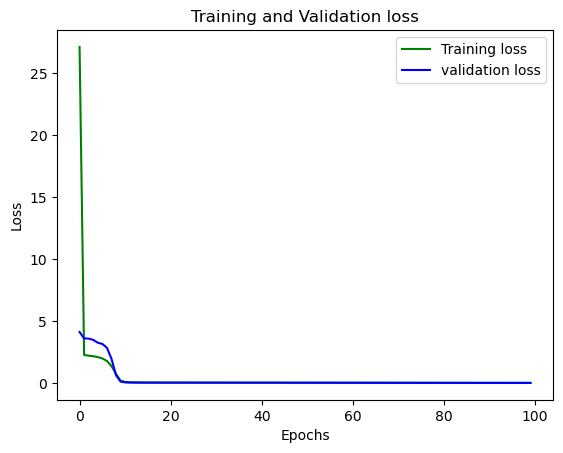

In [77]:
print(history.history.keys())

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,100)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('')
plt.show()

In [74]:
# Predict the train set
train_p=m.predict(X_train).flatten()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [75]:
# Generate 20 forecasts
ntest = X_test.shape[0]
m_input = X_train[-1:]
test_p = np.zeros(ntest)
for i in range(ntest):
    pred = m.predict(m_input)
    test_p[i] = pred[0]
    m_input = np.roll(m_input, -1)
    m_input[0,-1,0] = pred[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


C:\Users\loic\AppData\Local\Temp\ipykernel_6660\2272936751.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_p[i] = pred[0]
C:\Users\loic\AppData\Local\Temp\ipykernel_6660\2272936751.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_input[0,-1,0] = pred[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [80]:
#LSTM 
print('train:', metrics(data['DEXSFUS'][:2067],train_p))
print('test:' , metrics(data['DEXSFUS'][2067:],test_p))

train: (np.float64(0.17273365147452582), np.float64(0.008840160451077973))
test: (np.float64(0.1899454827835107), np.float64(0.008724711500500405))
